# <center>CS 7324 Lab 5
## <center>Francesco Trozzi (47779944) - George Sammit (04010135) - Megan Simons (46334773)

# Preparation


## Define & Prepare Class Variables

Most of the data preparation follows the previous labs, and is summarized here for convenience and reference:
* The unnamed index column is removed.
* There are 20 rows with missing data and are removed.
* Convert color, cut, clasrity to ordinal data
* Create the volume feature from the x, y, z attributes to provide an alternative view of size

Changes to the previous process are described below:
* In the past, we binned price into: first, with equal-size bins; and most recently into log-based bins.  However, now we attempt to predict the price given the features using regression, so it is unmodified.

In [2]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('diamonds.csv')

# Unused index column
print('Dropping the "Unnamed" column...\n')
df.drop(["Unnamed: 0"], axis=1, inplace=True)

# Remove 20 rows with empty data
print('Dropping the x, y, z rows with empty data...\n')
df[['x','y','z']] = df[['x','y','z']].replace(0,np.NaN)
df.dropna(inplace=True)

# Create valume, and drop x, y, z
df['volume'] = df['x'] * df['y'] * df['z']
df.drop(['x', 'y', 'z'], axis=1, inplace=True)

# Remove where carat > 2.0
print('Dropping the rows where carat > 2.0...\n')
df.drop(df[df.carat > 2.0].index, inplace=True)

# Convert color, cut, clasrity to ordinal data
print('Ordinalizing color, cut, clarity...\n')
df['cut_ord'] = df['cut']
df['color_ord'] = df['color']
df['clarity_ord'] = df['clarity']
df.cut_ord.replace(to_replace=df['cut_ord'].unique(), value = [4, 3, 2, 1, 0], inplace=True)
df.color_ord.replace(to_replace=df['color_ord'].unique(), value = [0, 1, 2, 3, 4, 5, 6], inplace=True)
df.clarity_ord.replace(to_replace=df['clarity_ord'].unique(), value = [2, 1, 4, 3, 5, 6, 0, 7], inplace=True)

Dropping the "Unnamed" column...

Dropping the x, y, z rows with empty data...

Dropping the rows where carat > 2.0...

Ordinalizing color, cut, clarity...



## Training/Test Split

In the present study, we aim to build a regression model that can predict the price of a diamond given its characteristics. Idially, we want to build a model that has low bias and low variance. These factors will influence our training/test split strategy. Furthermore, the splits should represent the characteristic of the entire dataset. To do so a stratified k-fold would be ideal, however in a regression model this is not possible. The best next thing to guarantee that each split is representative of the entire dataset is via shuffling. In order to achieve low variance and bias, we opt for a k-fold cross validation. We are going to use a 10 fold cross validation. This value is suggested by to be a good choice by Sebastian Raschka (https://sebastianraschka.com/faq/docs/number-of-kfolds.html#:~:text=(A%20useful%20reference%3A%20Shao%2C,an%20appropriate%20a%20good%20choice.)  Moreover, since our dataset has a large number of instances using large number of folds still results in al arge number of instances (~4000) for validation. Moreover, higher number of folds might result in lower bias, which is desireble, but in an increase in variance, which is not. In our Deep and Wide networks we plan to counter  the increase in variance by introducing l2 regularization and dropouts. The advantages of using a 10 fold CV comes with an increase of computational cost. For this reason, due to the size of the dataset and the resources available we are going to implement 5 fold cross validation.

In [4]:
y = df['price']
df.drop(['price'], axis=1, inplace=True)
df.reset_index()
X = df

In [5]:
from sklearn.model_selection import KFold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(len(X_train))
kfold = KFold(n_splits=5, random_state=42)

41629


## Identify Cross-Product Features

### Color, Cut, Clarity
These three along with carat (see below) are commonly througt to be the defining measures of a diamond.  Furthermore, as they increase, the price of the diamond does as well.  However, the sensitivity, e.g. going from, say color J to color I, and the trade-offs, e.g. increase of color and decrease of clarity are not as obvious.  We already have these as ordinal features, but here, we convert them to non-ordinal categorical features.  Combining these three will yield 5x7x8=280 possible combinations in our wide network

In [6]:
# Re-encode color, cut, clarity, buit this time we're not looking to make them ordinal
for col in ['cut', 'color', 'clarity']: 
    encoder = LabelEncoder()
    X_train[col + '_cat'] = encoder.fit_transform(X_train[col])
    X_test[col + '_cat'] = encoder.transform(X_test[col])

### Adding Carat
Carat weight is a continuous measure, but is frequently included in along with cut, color, clarity as a defining characteristic of a diamond, and the previous labs seem to indicate that it has a significant effect on price.  As noted in the previous lab, this dataset contains diamonds ranging between 0.2 and 5.1 carats. However, 96% of the data (51,786 diamonds) are under 2.0 carats. Caterorizing diamonds by 1/10th carat will add 19 categories for a total of 5,320 in our wide network. 

In [7]:
buckets = np.linspace(1, 20, 19, dtype=int)/10
X_train['carat_cat'] = pd.cut(X_train.carat, bins=buckets)
X_train['carat_cat'] = X_train['carat_cat'].apply(str)
X_test['carat_cat'] = pd.cut(X_test.carat, bins=buckets)
X_test['carat_cat'] = X_test['carat_cat'].apply(str)

encoder = LabelEncoder()
X_train['carat_cat'] = encoder.fit_transform(X_train['carat_cat'])
X_test['carat_cat'] = encoder.transform(X_test['carat_cat'])

## Cleanup and Final Features
* carat: Continious carat weight
* carat_cat: Bins of carat weight size by 1/10 carat
* cut_ord: Cut converted to ordinal integers
* cut_cat: Cut converted to categorical integers (unordered)
* color_ord: Color converted to ordinal integers
* color_cat: Color converted to categorical integers (unordered)
* clarity_ord: Clarity converted to ordinal integers
* clarity_cat: Clarity converted to categorical integers (unordered)
* depth: top-to-bottom length
* table: Length of flast top surface
* volume: Compination of dimensions into a shape approximation

In [8]:
X_train.drop(['cut', 'color', 'clarity'], axis=1, inplace=True)
X_test.drop(['cut', 'color', 'clarity'], axis=1, inplace=True)

X_train.info()
X_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41629 entries, 36776 to 3081
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   carat        41629 non-null  float64
 1   depth        41629 non-null  float64
 2   table        41629 non-null  float64
 3   volume       41629 non-null  float64
 4   cut_ord      41629 non-null  int64  
 5   color_ord    41629 non-null  int64  
 6   clarity_ord  41629 non-null  int64  
 7   cut_cat      41629 non-null  int64  
 8   color_cat    41629 non-null  int64  
 9   clarity_cat  41629 non-null  int64  
 10  carat_cat    41629 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 3.8 MB


,carat,depth,table,volume,cut_ord,color_ord,clarity_ord,cut_cat,color_cat,clarity_cat,carat_cat
36776,0.30,60.6,57.0,49.537365,4,0,6,2,1,6,1
81,0.26,62.1,60.0,42.007108,1,6,6,4,0,6,1
4503,0.90,60.3,63.0,147.025476,1,4,2,4,2,3,7
15665,1.32,62.2,58.0,214.553856,3,1,1,3,5,2,12
52086,0.72,62.3,57.0,120.060000,4,6,2,2,0,3,6


## Metric Selection (Megan)
[1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.



## Normalization

In [9]:
numerical_columns = ['carat', 'depth', 'table', 'volume', 'cut_ord', 'color_ord', 'clarity_ord']
categorical_columns = ['cut_cat', 'color_cat', 'clarity_cat', 'carat_cat'] 

In [10]:
# Normalize all but state
normalizer = StandardScaler().fit(X_train[numerical_columns])
X_train[numerical_columns] = normalizer.transform(X_train[numerical_columns])
X_test[numerical_columns] = normalizer.transform(X_test[numerical_columns])

# Modeling 

## Three Wide & Deep Networks
[2 points] Create at least three combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data.

### Utilities

In [11]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from sklearn import metrics as mt
from tensorflow.keras.layers import Dense, Activation, Input, Dropout
from tensorflow.keras.layers import Embedding, Flatten, Concatenate, concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from scipy import stats

In [12]:
def plot_history(histories, to_plot):
    fig, axs = plt.subplots(1,2, sharey=True, figsize=(12,6))
    for history in histories:
        axs[0].plot(history.history[to_plot])
        axs[1].plot(history.history['val_'+to_plot])

    axs[0].set_title('Training ')
    axs[1].set_title('Validation')
    for ax in axs.flat:
        ax.set(xlabel='Epochs')
    
    plt.suptitle('Model ' + to_plot.capitalize())
    plt.tight_layout()
    plt.show()
    
def plot_loss(histories):
    plot_history(histories, 'loss')
    
def plot_mae(histories):
    plot_history(histories, 'mae')

### Network  1
Cross columns in the wide branch, continuous numerical inputs in the deep branch

In [13]:
cross_columns = [['cut_cat', 'color_cat'],
                ['cut_cat', 'clarity_cat'],
                 ['cut_cat', 'carat_cat'],
                 ['color_cat', 'clarity_cat'],
                 ['color_cat', 'carat_cat'],
                 ['clarity_cat', 'carat_cat']]
l2_lambda = 0.01
X_train[categorical_columns] = X_train[categorical_columns].astype(str)
X_test[categorical_columns] = X_test[categorical_columns].astype(str)

histories1 = []
for train, test in kfold.split(X_train):
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_deep_branch_outputs = []
    all_wide_branch_outputs = []
    X_ktrain, X_ktest = X_train.iloc[train], X_train.iloc[test]
    y_ktrain, y_ktest = y_train.iloc[train], y_train.iloc[test]
    X_train_num = X_ktrain[numerical_columns].values
    X_test_num = X_ktest[numerical_columns].values
    
    for cols in cross_columns:
        # encode crossed columns as ints for the embedding
        enc = LabelEncoder()

        # create crossed labels
        X_crossed_train = X_ktrain[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = X_ktest[cols].apply(lambda x: '_'.join(x), axis=1)
        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)
    

    # merge the branches together
    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=1, activation='sigmoid', kernel_initializer='glorot_uniform', kernel_regularizer=l2(l2_lambda), name='wide_combined')(wide_branch)
    wide_branch = (Dropout(0.25))(wide_branch)
    
    # merge the deep branches together
    all_inputs.append(Input(shape=(X_train_num.shape[1]), sparse=False, name='X_Numeric'))
    deep_branch = Dense(units=50,activation='relu', kernel_initializer='he_uniform', name='deep1')(all_inputs[-1])
    deep_branch = (Dropout(0.25))(deep_branch)
    deep_branch = Dense(units=25,activation='relu', kernel_initializer='he_uniform', name='deep2')(deep_branch)
    deep_branch = (Dropout(0.25))(deep_branch)
    deep_branch = Dense(units=10,activation='relu', kernel_initializer='he_uniform', name='deep3')(deep_branch)
    deep_branch = (Dropout(0.25))(deep_branch)

    final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
    final_branch = (Dropout(0.5))(final_branch)
    final_branch = Dense(units=1, activation='linear', kernel_initializer='glorot_uniform', name='combined')(final_branch)
    
    model1 = Model(inputs=all_inputs, outputs=final_branch)

    model1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    history = model1.fit(x=X_ints_train+ [X_train_num], 
                         y=y_ktrain,  
                         validation_data = (X_ints_test + [X_test_num], y_ktest),
                        epochs=50, 
                        batch_size=32,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=4)])
    histories1.append(history)

Epoch 1/50
1041/1041 [==============================] - 5s 4ms/step - loss: 15912394.0000 - mae: 2637.2283 - val_loss: 3831342.2500 - val_mae: 1028.0702
Epoch 2/50
1041/1041 [==============================] - 4s 4ms/step - loss: 6451384.0000 - mae: 1565.0549 - val_loss: 3475548.0000 - val_mae: 981.5964
Epoch 3/50
1041/1041 [==============================] - 4s 4ms/step - loss: 6128945.0000 - mae: 1522.2188 - val_loss: 3380770.5000 - val_mae: 954.9142
Epoch 4/50
1041/1041 [==============================] - 4s 4ms/step - loss: 6103936.5000 - mae: 1494.8021 - val_loss: 3138081.0000 - val_mae: 875.8157
Epoch 5/50
1041/1041 [==============================] - 4s 4ms/step - loss: 6109431.0000 - mae: 1504.7213 - val_loss: 3333426.7500 - val_mae: 942.2300
Epoch 6/50
1041/1041 [==============================] - 4s 4ms/step - loss: 6089028.5000 - mae: 1499.9423 - val_loss: 3256763.0000 - val_mae: 917.9971
Epoch 7/50
1041/1041 [==============================] - 4s 4ms/step - loss: 5973866.0000 - m

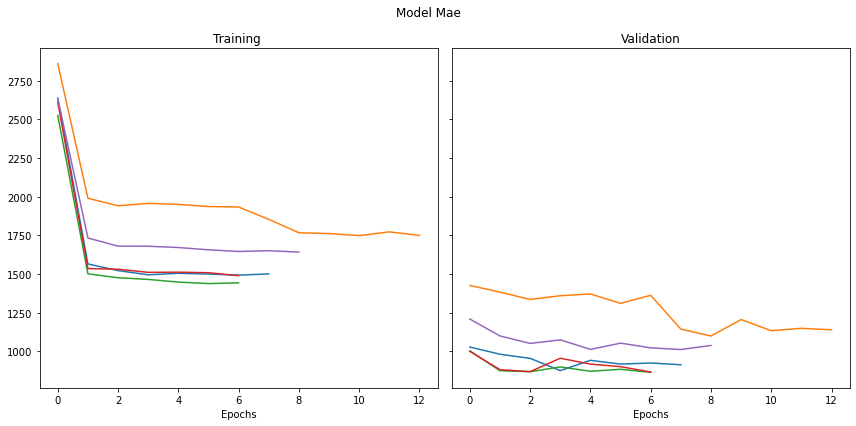

In [14]:
plot_mae(histories1)

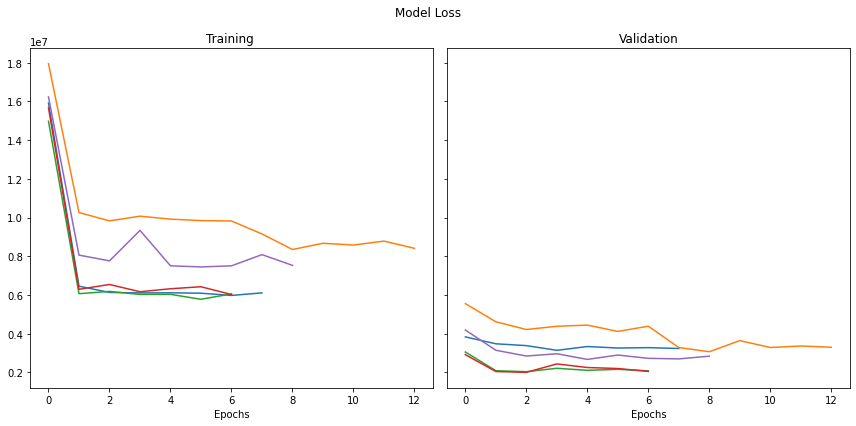

In [15]:
plot_loss(histories1)

### Network #2
Cross columns in the wide branch, continuous numerical inputs and integers of categorical in the deep branch


In [16]:
histories2 = []
for train, test in kfold.split(X_train):
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_deep_branch_outputs = []
    all_wide_branch_outputs = []
    X_ktrain, X_ktest = X_train.iloc[train], X_train.iloc[test]
    y_ktrain, y_ktest = y_train.iloc[train], y_train.iloc[test]
    X_train_num = X_ktrain[numerical_columns].values
    X_test_num = X_ktest[numerical_columns].values
    
    for cols in categorical_columns:
        # create labels
        X_cat_train = X_ktrain[cols].astype(int)
        X_cat_test = X_ktest[cols].astype(int)
        X_ints_train.append(X_cat_train.values)
        X_ints_test.append(X_cat_test.values)

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = cols)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = cols+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)
    
    for cols in cross_columns:
        # encode crossed columns as ints for the embedding
        enc = LabelEncoder()

        # create crossed labels
        X_crossed_train = X_ktrain[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = X_ktest[cols].apply(lambda x: '_'.join(x), axis=1)
        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)
    

    # merge the branches together
    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=1, activation='sigmoid', kernel_initializer='glorot_uniform', kernel_regularizer=l2(l2_lambda), name='wide_combined')(wide_branch)
    wide_branch = (Dropout(0.25))(wide_branch)

    # create dense input branch for numeric
    all_inputs.append(Input(shape=(X_train_num.shape[1]), sparse=False, name='X_Numeric'))
    xDense = Dense(units=50, activation='relu', kernel_regularizer=l2(l2_lambda), name='num_1')(all_inputs[-1])
    all_deep_branch_outputs.append(xDense)

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), name='deep1')(deep_branch)
    deep_branch = (Dropout(0.25))(deep_branch)
    deep_branch = Dense(units=25,activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), name='deep2')(deep_branch)
    deep_branch = (Dropout(0.25))(deep_branch)
    deep_branch = Dense(units=10,activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), name='deep3')(deep_branch)
    deep_branch = (Dropout(0.25))(deep_branch)

    final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
    final_branch = (Dropout(0.5))(final_branch)
    final_branch = Dense(units=1, activation='linear', kernel_initializer='glorot_uniform', name='combined')(final_branch)
    
    model2 = Model(inputs=all_inputs, outputs=final_branch)

    model2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    history = model2.fit(x=X_ints_train+ [X_train_num], 
                         y=y_ktrain,  
                         validation_data = (X_ints_test + [X_test_num], y_ktest),
                        epochs=50, 
                        batch_size=32,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=4)])
    histories2.append(history)

Epoch 1/50
1041/1041 [==============================] - 6s 6ms/step - loss: 13308795.0000 - mae: 2328.9778 - val_loss: 4238139.5000 - val_mae: 1146.8088
Epoch 2/50
1041/1041 [==============================] - 5s 5ms/step - loss: 8451419.0000 - mae: 1773.5331 - val_loss: 4465095.0000 - val_mae: 1249.4476
Epoch 3/50
1041/1041 [==============================] - 5s 5ms/step - loss: 8320007.0000 - mae: 1754.2416 - val_loss: 3971057.5000 - val_mae: 1128.3932
Epoch 4/50
1041/1041 [==============================] - 5s 5ms/step - loss: 8168945.0000 - mae: 1747.6945 - val_loss: 3926182.0000 - val_mae: 1143.2449
Epoch 5/50
1041/1041 [==============================] - 5s 5ms/step - loss: 7948845.0000 - mae: 1732.2654 - val_loss: 3772872.0000 - val_mae: 1098.9847
Epoch 6/50
1041/1041 [==============================] - 5s 5ms/step - loss: 6703746.5000 - mae: 1571.5363 - val_loss: 2893591.0000 - val_mae: 774.7068
Epoch 7/50
1041/1041 [==============================] - 6s 5ms/step - loss: 5693468.0000

1041/1041 [==============================] - 5s 5ms/step - loss: 6033401.5000 - mae: 1460.7135 - val_loss: 1942561.1250 - val_mae: 832.7700
Epoch 3/50
1041/1041 [==============================] - 5s 5ms/step - loss: 6202788.0000 - mae: 1395.7543 - val_loss: 1509516.5000 - val_mae: 741.7538
Epoch 4/50
1041/1041 [==============================] - 5s 5ms/step - loss: 5949078.0000 - mae: 1359.9518 - val_loss: 1520955.5000 - val_mae: 765.9760
Epoch 5/50
1041/1041 [==============================] - 5s 5ms/step - loss: 4736909.0000 - mae: 1319.7009 - val_loss: 1229248.7500 - val_mae: 669.5056
Epoch 6/50
1041/1041 [==============================] - 5s 5ms/step - loss: 4946384.0000 - mae: 1313.4379 - val_loss: 1565299.2500 - val_mae: 783.7549
Epoch 7/50
1041/1041 [==============================] - 5s 5ms/step - loss: 4627410.5000 - mae: 1296.2260 - val_loss: 1478910.7500 - val_mae: 770.0162
Epoch 8/50
1041/1041 [==============================] - 5s 5ms/step - loss: 5043246.5000 - mae: 1302.2028

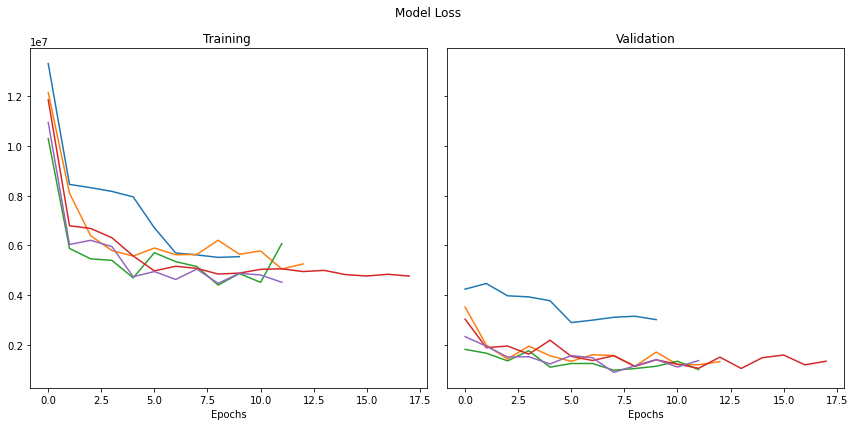

In [17]:
plot_loss(histories2)

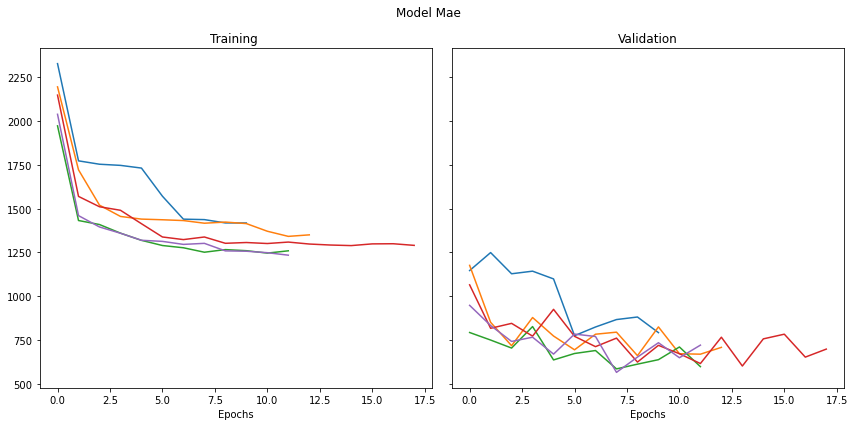

In [18]:
plot_mae(histories2)

### Network #3
Cross columns in the wide branch, deep branch for numerical inputs, output of the first deep branch merged with integers of categorical in another the deep branch.

In [19]:
histories3 = []
for train, test in kfold.split(X_train):
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_deep_branch_outputs = []
    all_wide_branch_outputs = []
    X_ktrain, X_ktest = X_train.iloc[train], X_train.iloc[test]
    y_ktrain, y_ktest = y_train.iloc[train], y_train.iloc[test]
    X_train_num = X_ktrain[numerical_columns].values
    X_test_num = X_ktest[numerical_columns].values
    
    for cols in categorical_columns:
        # create labels
        X_cat_train = X_ktrain[cols].astype(int)
        X_cat_test = X_ktest[cols].astype(int)
        X_ints_train.append(X_cat_train.values)
        X_ints_test.append(X_cat_test.values)

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = cols)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = cols+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)
    
    for cols in cross_columns:
        # encode crossed columns as ints for the embedding
        enc = LabelEncoder()

        # create crossed labels
        X_crossed_train = X_ktrain[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = X_ktest[cols].apply(lambda x: '_'.join(x), axis=1)
        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)
    

    # merge the branches together
    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=1, activation='sigmoid', kernel_initializer='glorot_uniform', kernel_regularizer=l2(l2_lambda), name='wide_combined')(wide_branch)
    wide_branch = (Dropout(0.25))(wide_branch)

    # create dense input branch for numeric
    all_inputs.append(Input(shape=(X_train_num.shape[1]), sparse=False, name='X_Numeric'))
    xDense = Dense(units=50, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), name='num_1')(all_inputs[-1])
    xDense = (Dropout(0.25))(xDense)
    xDense = Dense(units=40, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), name='num_2')(xDense)
    xDense = (Dropout(0.25))(xDense)
    xDense = Dense(units=30, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), name='num_3')(xDense)
    xDense = (Dropout(0.25))(xDense)
    xDense = Dense(units=15, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), name='num_4')(xDense)
    xDense = (Dropout(0.25))(xDense)
    all_deep_branch_outputs.append(xDense)

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), name='deep1')(deep_branch)
    deep_branch = (Dropout(0.25))(deep_branch)
    deep_branch = Dense(units=25, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), name='deep2')(deep_branch)
    deep_branch = (Dropout(0.25))(deep_branch)
    deep_branch = Dense(units=10, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), name='deep3')(deep_branch)
    deep_branch = (Dropout(0.25))(deep_branch)

    final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
    final_branch = (Dropout(0.5))(final_branch)
    final_branch = Dense(units=1, activation='linear', kernel_initializer='glorot_uniform', name='combined')(final_branch)
    
    model3 = Model(inputs=all_inputs, outputs=final_branch)

    model3.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    history = model3.fit(x=X_ints_train+ [X_train_num], 
                         y=y_ktrain,  
                         validation_data = (X_ints_test + [X_test_num], y_ktest),
                        epochs=50, 
                        batch_size=32,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=4)])
    histories3.append(history)

Epoch 1/50
1041/1041 [==============================] - 6s 6ms/step - loss: 10985724.0000 - mae: 2107.7673 - val_loss: 3628136.2500 - val_mae: 987.3547
Epoch 2/50
1041/1041 [==============================] - 6s 6ms/step - loss: 7314537.5000 - mae: 1647.0276 - val_loss: 3934674.7500 - val_mae: 1108.7294
Epoch 3/50
1041/1041 [==============================] - 6s 6ms/step - loss: 6219533.0000 - mae: 1488.7792 - val_loss: 3694550.0000 - val_mae: 1029.0460
Epoch 4/50
1041/1041 [==============================] - 6s 6ms/step - loss: 5950177.5000 - mae: 1453.6176 - val_loss: 4404148.0000 - val_mae: 1201.1635
Epoch 5/50
1041/1041 [==============================] - 6s 6ms/step - loss: 5871055.0000 - mae: 1446.4397 - val_loss: 3933675.0000 - val_mae: 1117.7654
Epoch 1/50
1041/1041 [==============================] - 6s 6ms/step - loss: 16357672.0000 - mae: 2681.3306 - val_loss: 6629276.0000 - val_mae: 1736.7687
Epoch 2/50
1041/1041 [==============================] - 6s 6ms/step - loss: 11487579.00

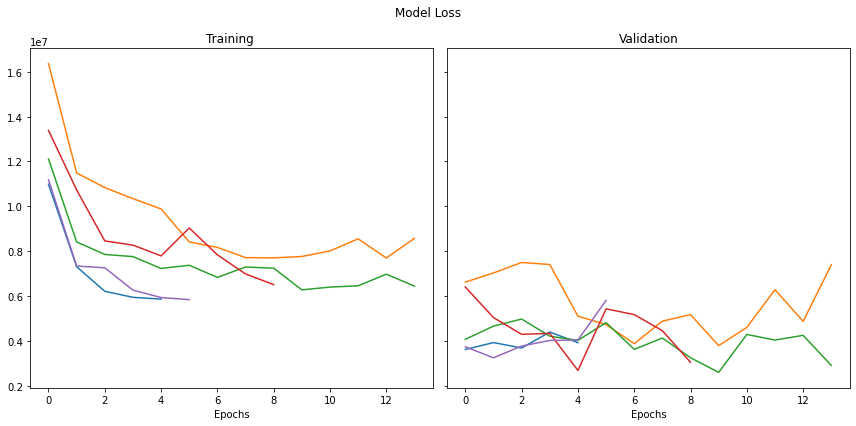

In [20]:
plot_loss(histories3)

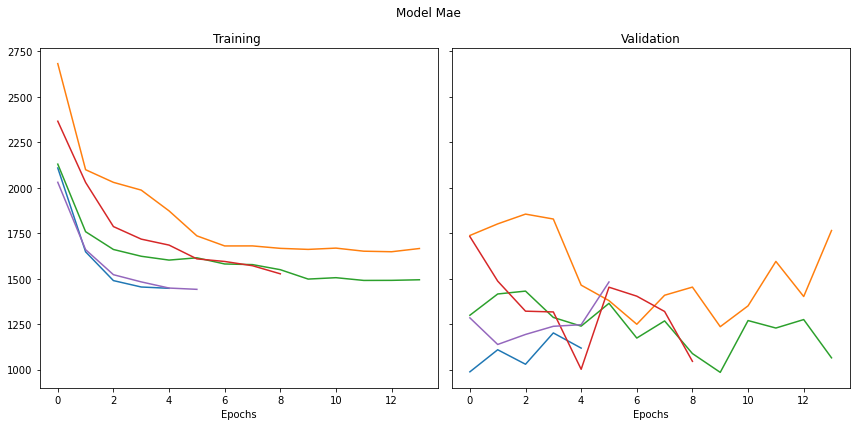

In [21]:
plot_mae(histories3)

In [22]:
tot = [histories1, histories2, histories3]
flat = [[], [], []]
name = ['Model 1', 'Model 2', 'Model 3']
print('Minimum Mean Absolute Error:')
for t in range(len(tot)):
    folds = 0
    minimum = 1000000
    maximum = 0
    for history in tot[t]:
        folds += 1
        tmp = min(history.history['val_mae'])
        if tmp < minimum:
            minimum = tmp
        if tmp > maximum:
            maximum = tmp
    print(name[t]+': '+ str(minimum) + ' (folds=' + str(folds) + ')')

Minimum Mean Absolute Error:
Model 1: 864.4020385742188 (folds=5)
Model 2: 565.0552368164062 (folds=5)
Model 3: 984.4130859375 (folds=5)


In [23]:
def flatten(histories):
    flat = np.array([])
    for history in histories:
        flat = np.append(flat, min(history.history['val_mae']))
    return flat

flat_histories1 = flatten(histories1)
flat_histories2 = flatten(histories2)
flat_histories3 = flatten(histories3)

print("Normality Test")
print(stats.shapiro(flat_histories1))
print(stats.shapiro(flat_histories2))
print(stats.shapiro(flat_histories3))


print('\nModel 2 v Model 3')
print(stats.describe(flat_histories2))
print(stats.describe(flat_histories3))
print(stats.ttest_rel(flat_histories2, flat_histories3))

Normality Test
ShapiroResult(statistic=0.7998403310775757, pvalue=0.08079195767641068)
ShapiroResult(statistic=0.8659867644309998, pvalue=0.250550776720047)
ShapiroResult(statistic=0.8117169141769409, pvalue=0.10061624646186829)

Model 2 v Model 3
DescribeResult(nobs=5, minmax=(565.0552368164062, 774.7068481445312), mean=637.292333984375, variance=7171.04931451492, skewness=0.9387803889524613, kurtosis=-0.6098388361058111)
DescribeResult(nobs=5, minmax=(984.4130859375, 1235.468017578125), mean=1069.2446533203124, variance=12711.473796737566, skewness=0.67092470952359, kurtosis=-1.252512287389156)
Ttest_relResult(statistic=-6.42417538848168, pvalue=0.003018506607139213)


Regarding the above, we see that Model 2 had the lowest MAE over the 10 folds.  Since Model 1 stopped after only three, we cannot compare it to the others statistically.  Given a sample size of 10, the normality tests lack sufficient power, but we assume normality.  With that assumption, the t-test is appropriate, and we fail to reject the null hypothesis -- models 2 and 3 a probably equivalent

## Adding Layers

Here, we start out with Model 2 based on the above analysis.  It has 4 layers as implemented.  Here, we chose to ivnestigate the effect of the number of layers in the deep network by creating two new models in which the first has half of the orginal hidden layers and the second has the double. 

In [24]:
histories2_1 = []
histories2_2 = []
for train, test in kfold.split(X_train):
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_deep_branch_outputs = []
    all_wide_branch_outputs = []
    X_ktrain, X_ktest = X_train.iloc[train], X_train.iloc[test]
    y_ktrain, y_ktest = y_train.iloc[train], y_train.iloc[test]
    X_train_num = X_ktrain[numerical_columns].values
    X_test_num = X_ktest[numerical_columns].values
    
    for cols in categorical_columns:
        # create labels
        X_cat_train = X_ktrain[cols].astype(int)
        X_cat_test = X_ktest[cols].astype(int)
        X_ints_train.append(X_cat_train.values)
        X_ints_test.append(X_cat_test.values)

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = cols)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = cols+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)
    
    for cols in cross_columns:
        # encode crossed columns as ints for the embedding
        enc = LabelEncoder()

        # create crossed labels
        X_crossed_train = X_ktrain[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = X_ktest[cols].apply(lambda x: '_'.join(x), axis=1)
        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)
    

    # merge the branches together
    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=1, activation='sigmoid', kernel_initializer='glorot_uniform', kernel_regularizer=l2(l2_lambda), name='wide_combined')(wide_branch)
    wide_branch = (Dropout(0.25))(wide_branch)

    # create dense input branch for numeric
    all_inputs.append(Input(shape=(X_train_num.shape[1]), sparse=False, name='X_Numeric'))
    xDense = Dense(units=50, activation='relu', kernel_regularizer=l2(l2_lambda), name='num_1')(all_inputs[-1])
    all_deep_branch_outputs.append(xDense)

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch = Dense(units=50,activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), name='deep1')(deep_branch)
    deep_branch = (Dropout(0.25))(deep_branch)

    final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
    final_branch = (Dropout(0.5))(final_branch)
    final_branch = Dense(units=1, activation='linear', kernel_initializer='glorot_uniform', name='combined')(final_branch)
    
    model2_1 = Model(inputs=all_inputs, outputs=final_branch)

    model2_1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    history2_1 = model2_1.fit(x=X_ints_train+ [X_train_num], 
                         y=y_ktrain,  
                         validation_data = (X_ints_test + [X_test_num], y_ktest),
                        epochs=50, 
                        batch_size=32,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=4)])
    histories2_1.append(history2_1)
    
    # merge the deep branches together
    deep_branch2 = concatenate(all_deep_branch_outputs,name='concat_embeds')
    deep_branch2 = Dense(units=50, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), name='deep1')(deep_branch)
    deep_branch2 = (Dropout(0.25))(deep_branch)
    deep_branch2 = Dense(units=40, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), name='deep2')(deep_branch)
    deep_branch2 = (Dropout(0.25))(deep_branch)
    deep_branch2 = Dense(units=30, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), name='deep3')(deep_branch)
    deep_branch2 = (Dropout(0.25))(deep_branch)
    deep_branch2 = Dense(units=30, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), name='deep1')(deep_branch)
    deep_branch2 = (Dropout(0.25))(deep_branch)
    deep_branch2 = Dense(units=20, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), name='deep2')(deep_branch)
    deep_branch2 = (Dropout(0.25))(deep_branch)
    deep_branch2 = Dense(units=10, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), name='deep3')(deep_branch)
    deep_branch2 = (Dropout(0.25))(deep_branch)

    
    final_branch2 = concatenate([wide_branch, deep_branch2], name='concat_deep_wide')
    final_branch2 = (Dropout(0.5))(final_branch2)
    final_branch2 = Dense(units=1, activation='linear', kernel_initializer='glorot_uniform', name='combined')(final_branch2)
    
    model2_2 = Model(inputs=all_inputs, outputs=final_branch2)

    model2_2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    history2_2 = model2_2.fit(x=X_ints_train+ [X_train_num], 
                         y=y_ktrain,  
                         validation_data = (X_ints_test + [X_test_num], y_ktest),
                        epochs=50, 
                        batch_size=32,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=4)])
    histories2_2.append(history2_2)

Epoch 1/50
1041/1041 [==============================] - 5s 5ms/step - loss: 16955908.0000 - mae: 2742.9834 - val_loss: 3849227.2500 - val_mae: 974.1596
Epoch 2/50
1041/1041 [==============================] - 5s 4ms/step - loss: 2509196.2500 - mae: 939.9789 - val_loss: 2650025.5000 - val_mae: 680.6168
Epoch 3/50
1041/1041 [==============================] - 4s 4ms/step - loss: 2179569.2500 - mae: 875.9149 - val_loss: 2589484.0000 - val_mae: 615.9250
Epoch 4/50
1041/1041 [==============================] - 5s 4ms/step - loss: 2000618.7500 - mae: 835.9551 - val_loss: 2528599.5000 - val_mae: 574.6236
Epoch 5/50
1041/1041 [==============================] - 5s 4ms/step - loss: 1946183.1250 - mae: 825.8777 - val_loss: 2544834.2500 - val_mae: 558.9852
Epoch 6/50
1041/1041 [==============================] - 5s 4ms/step - loss: 1864044.7500 - mae: 823.8121 - val_loss: 2484181.0000 - val_mae: 556.1182
Epoch 7/50
1041/1041 [==============================] - 5s 4ms/step - loss: 1825332.0000 - mae: 82

1041/1041 [==============================] - 5s 4ms/step - loss: 2586951.0000 - mae: 883.6776 - val_loss: 1109324.7500 - val_mae: 605.4916
Epoch 4/50
1041/1041 [==============================] - 5s 4ms/step - loss: 2806455.0000 - mae: 852.4595 - val_loss: 966257.4375 - val_mae: 562.4760
Epoch 5/50
1041/1041 [==============================] - 5s 4ms/step - loss: 2422422.7500 - mae: 834.1917 - val_loss: 932936.0625 - val_mae: 555.9393
Epoch 6/50
1041/1041 [==============================] - 5s 4ms/step - loss: 2280715.0000 - mae: 838.8821 - val_loss: 856429.8125 - val_mae: 538.4545
Epoch 7/50
1041/1041 [==============================] - 5s 4ms/step - loss: 2210791.5000 - mae: 838.8881 - val_loss: 821559.8125 - val_mae: 537.1845
Epoch 8/50
1041/1041 [==============================] - 5s 4ms/step - loss: 2106838.5000 - mae: 838.3179 - val_loss: 793642.3750 - val_mae: 534.5483
Epoch 9/50
1041/1041 [==============================] - 5s 4ms/step - loss: 2761884.7500 - mae: 840.9182 - val_loss:

Epoch 18/50
1041/1041 [==============================] - 5s 4ms/step - loss: 2030369.1250 - mae: 831.9895 - val_loss: 689016.5625 - val_mae: 508.6447
Epoch 19/50
1041/1041 [==============================] - 5s 4ms/step - loss: 2209570.7500 - mae: 826.1167 - val_loss: 707227.3750 - val_mae: 511.3609
Epoch 20/50
1041/1041 [==============================] - 5s 4ms/step - loss: 2134789.7500 - mae: 819.0043 - val_loss: 698579.0625 - val_mae: 507.6912
Epoch 21/50
1041/1041 [==============================] - 5s 4ms/step - loss: 2212241.0000 - mae: 814.2590 - val_loss: 691679.3125 - val_mae: 506.4622
Epoch 22/50
1041/1041 [==============================] - 5s 4ms/step - loss: 1926458.6250 - mae: 817.3472 - val_loss: 700504.1250 - val_mae: 505.5184
Epoch 1/50
1041/1041 [==============================] - 5s 5ms/step - loss: 7615696.5000 - mae: 1676.3788 - val_loss: 896766.6875 - val_mae: 544.7842
Epoch 2/50
1041/1041 [==============================] - 5s 4ms/step - loss: 2512994.5000 - mae: 918.

Epoch 13/50
1041/1041 [==============================] - 5s 5ms/step - loss: 3099654.2500 - mae: 928.8976 - val_loss: 795735.5625 - val_mae: 542.5468
Epoch 14/50
1041/1041 [==============================] - 5s 4ms/step - loss: 2678356.5000 - mae: 934.3477 - val_loss: 712918.1875 - val_mae: 516.5169
Epoch 15/50
1041/1041 [==============================] - 5s 4ms/step - loss: 2422890.0000 - mae: 930.3243 - val_loss: 724027.3125 - val_mae: 519.5773
Epoch 16/50
1041/1041 [==============================] - 5s 4ms/step - loss: 2610678.7500 - mae: 926.1375 - val_loss: 753678.3125 - val_mae: 526.8068
Epoch 17/50
1041/1041 [==============================] - 5s 4ms/step - loss: 2624819.7500 - mae: 922.3906 - val_loss: 786518.5625 - val_mae: 540.0692
Epoch 18/50
1041/1041 [==============================] - 5s 4ms/step - loss: 2437784.0000 - mae: 919.3426 - val_loss: 722772.9375 - val_mae: 516.4861


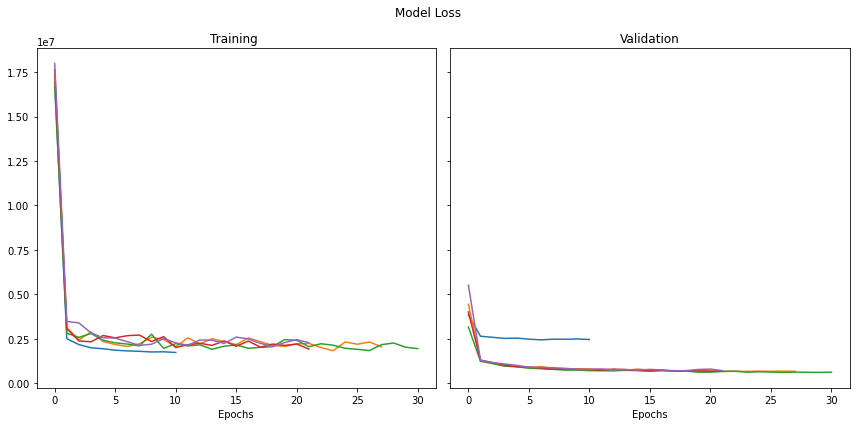

In [25]:
plot_loss(histories2_1)

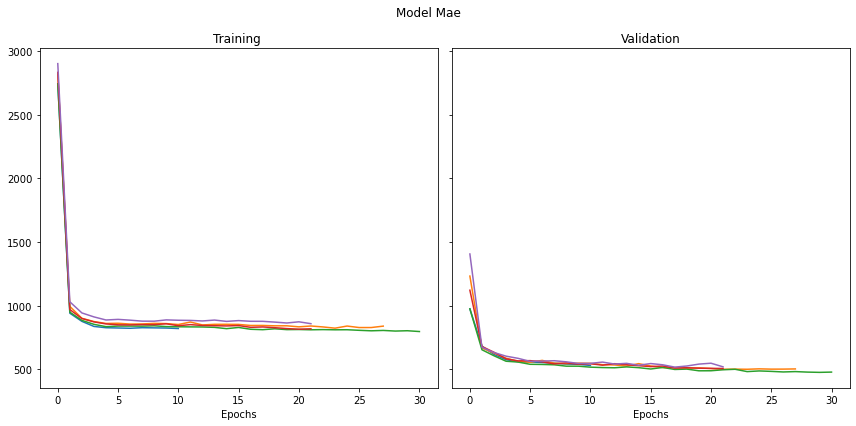

In [26]:
plot_mae(histories2_1)

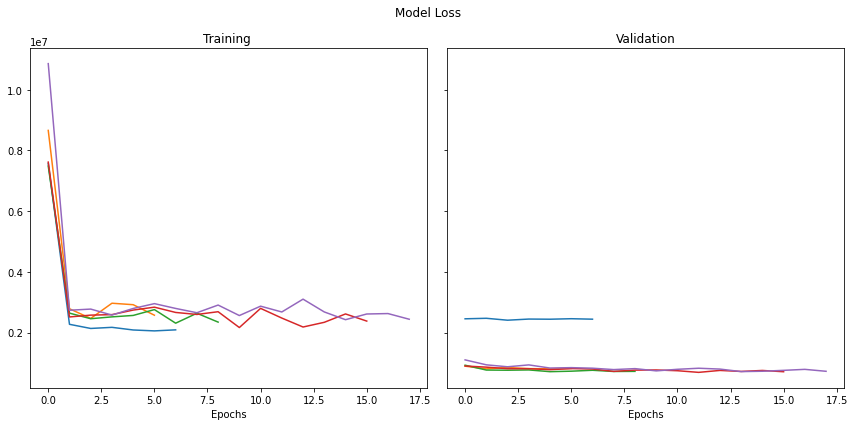

In [27]:
plot_loss(histories2_2)

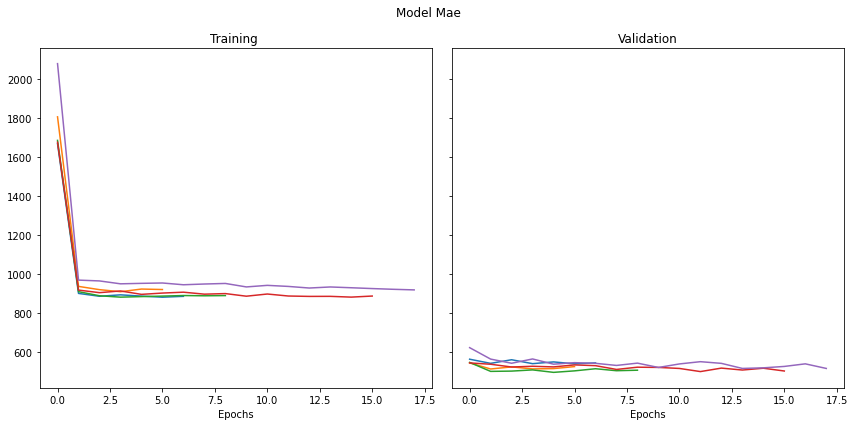

In [28]:
plot_mae(histories2_2)

In [30]:
flat_histories2_1 = flatten(histories2_1)
flat_histories2_2 = flatten(histories2_2)

print("Normality Test")
print(stats.shapiro(flat_histories2_1))
print(stats.shapiro(flat_histories2_2))


print('\nModel 2 v Model 2.1')
print(stats.describe(flat_histories2))
print(stats.describe(flat_histories2_1))
print(stats.ttest_rel(flat_histories2, flat_histories2_1))

print('\nModel 2 v Model 2.2')
print(stats.describe(flat_histories2))
print(stats.describe(flat_histories2_2))
print(stats.ttest_rel(flat_histories2, flat_histories2_2))

print('\nModel 2.1 v Model 2.2')
print(stats.describe(flat_histories2_1))
print(stats.describe(flat_histories2_2))
print(stats.ttest_rel(flat_histories2_1, flat_histories2_2))

Normality Test
ShapiroResult(statistic=0.9791082143783569, pvalue=0.9297922849655151)
ShapiroResult(statistic=0.9180126190185547, pvalue=0.5172009468078613)

Model 2 v Model 2.1
DescribeResult(nobs=5, minmax=(565.0552368164062, 774.7068481445312), mean=637.292333984375, variance=7171.04931451492, skewness=0.9387803889524613, kurtosis=-0.6098388361058111)
DescribeResult(nobs=5, minmax=(475.0445251464844, 529.34375), mean=505.0876037597656, variance=412.5982787765563, skewness=-0.38827935946367953, kurtosis=-0.8381835009669847)
Ttest_relResult(statistic=3.9472255477967715, pvalue=0.01685720121707118)

Model 2 v Model 2.2
DescribeResult(nobs=5, minmax=(565.0552368164062, 774.7068481445312), mean=637.292333984375, variance=7171.04931451492, skewness=0.9387803889524613, kurtosis=-0.6098388361058111)
DescribeResult(nobs=5, minmax=(496.37322998046875, 540.2099609375), mean=513.4198059082031, variance=297.0356290603056, skewness=0.6594953734951563, kurtosis=-0.7733313894176828)
Ttest_relResult

Similar to the previous t-test, we assume normality.  With that assumption,  we fail to reject the null hypothess -- models 2 and 3 a probably equivalent